<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Copy_of_Copy_of_Alpha_RNNs_regime_switching_DK(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive')

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces
from sklearn.preprocessing import StandardScaler

	
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
# To make this notebook's output stable across runs
#def reset_graph(seed=42):
#    tf.reset_default_graph()
#    tf.set_random_seed(seed)
#    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
def simulateAlphaRNN(p, n, plain=False, fixed_alpha=False, alpha=1.0):
    """
    p: is the order of the model
    n: is the length of the simulated data
    plain: is a boolean indicating whether to simulate plain RNN or alpha-RNN
    fixed_alpha: is a boolean indicating whether alpha should be dynamic or static (fixed)
    alpha: the default value of alpha (ignored if fixed_alpha=False)
    """
    
    x = np.array([0]*n, dtype='float32')
    x[:p]= 1 # initialize the first p values
    alpha_hat_ar=np.array([0]*n, dtype='float32')
    s_ar=np.array([0]*len(x), dtype='float32')
    h_tilde = 0 
    s=0.5
    s_=0.0
    if fixed_alpha:
        alpha_hat=alpha
    for i in range(len(x)):
        #if plain:
        h_hat=0 # there is no recurrent step at the last lag: h_hat=sigma(w*x[i-p+j] + b)
        #if i%100 ==0:  
        #  if s==0:
        #    s=1
        #  else:
        #    s=0  
        for j in range(p):
            if (i-p+j)>=0:
                #h_hat=sigma(w*x[i-p+j] + u*h_tilde + b)
                if not plain:
                    if not fixed_alpha:
                      alpha_hat=sigmoid(w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha)    
                    h_tilde = (1-alpha_hat)*h_tilde + alpha_hat*h_hat
                else:
                    h_tilde=h_hat
                
                s_=sigmoid(5000*(w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha))
                h_hat=np.tanh(w_h*x[i-p+j] + (s_*u_h1+(1-s_)*u_h2)*h_tilde + b_h)    
            
        x[i]=h_tilde + 0.001*np.random.randn()
        alpha_hat_ar[i]=alpha_hat
        s_ar[i] = s_ #w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha
        
    return(x, alpha_hat_ar, s_ar)   

In [0]:
w_h,w_alpha = [1, -1.0] # weight
u_h1,u_h2,u_alpha =[1.0 , 0.1, 0.1]
b_h,b_alpha=[0,  0.5]

In [0]:
np.random.seed(0)

In [0]:
x_t_RNN, alpha_hat_ar, s_ar=simulateAlphaRNN(30, 2000, plain=False, fixed_alpha=True, alpha=0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


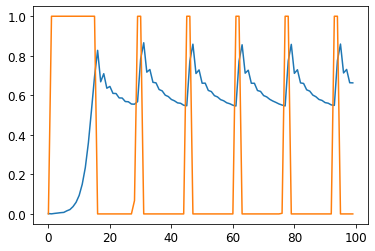

In [0]:
plt.plot(x_t_RNN[:100])
plt.plot(s_ar[:100])

In [0]:
#p = 30 # the number of lags (in both the data and the models)
#vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]


In [0]:
df = pd.read_csv("/Users/macbookpro/Desktop/Data/Load3.csv")
df = pd.DataFrame(df)
df.head()

#zip_path = tf.keras.utils.get_file(
#    origin='https://drive.google.com/open?id=1KTEKHyXxx0S2ZFXp1evZHoU_Em1PIPxY',
    #'https://datahub.io/core/finance-vix#resource-finance-vix_zip',
    #'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#    fname='finance-vix_zip.zip', #'jena_climate_2009_2016.csv.zip',
#    extract=True)
#csv_path, _ = os.path.splitext(zip_path)
#df = pd.read_csv(csv_path)
#df.head()

,utc_timestamp,DK_2_load_actual_net_consumption_tso,DK_2_load_actual_tso
0,2008-01-01T00:00:00Z,1468.0,1499.4
1,2008-01-01T01:00:00Z,1400.2,1439.4
2,2008-01-01T02:00:00Z,1334.8,1372.0
3,2008-01-01T03:00:00Z,1290.1,1324.9
4,2008-01-01T04:00:00Z,1286.1,1314.4


In [0]:
#uni_data = df['DE_load_actual_entsoe_transparency']
uni_data = df['DK_2_load_actual_net_consumption_tso']
uni_date = df['utc_timestamp']
uni_data.index = uni_date
uni_data.head()

utc_timestamp
2008-01-01T00:00:00Z    1468.0
2008-01-01T01:00:00Z    1400.2
2008-01-01T02:00:00Z    1334.8
2008-01-01T03:00:00Z    1290.1
2008-01-01T04:00:00Z    1286.1
Name: DK_2_load_actual_net_consumption_tso, dtype: float64

In [0]:
#df = pd.DataFrame(x_t_RNN, columns=['x'])

In [0]:
#use_features = ['x'] 
#target = 'x'
#use_features = ['DE_load_actual_entsoe_transparency']
use_features = ['DK_2_load_actual_net_consumption_tso']
target = 'DK_2_load_actual_net_consumption_tso'

n_steps = 30 # number of lags to include in the model

train_weight = 0.8
split = int(0.2*len(df)*train_weight)
uni_train_mean = uni_data[:split].mean()
uni_train_std = uni_data[:split].std()
uni_data = (uni_data - uni_train_mean)/uni_train_std
#print(uni_data)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[use_features])
scaled_df = pd.DataFrame(scaled_df, columns=['DK_2_load_actual_net_consumption_tso'])
df_train = scaled_df[use_features].iloc[:split]
#df_train = uni_data.iloc[:split]
#print(df)
df_test = scaled_df[use_features].iloc[split:]
#df_test = uni_data.iloc[split:]

In [0]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(15746, 30, 1) (15746, 1, 1) (82837, 30, 1) (82837, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

15746


In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        #self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.sigmoid(self.alpha)* output + (1-K.sigmoid(self.alpha))* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
 class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2*self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:
class RSCell(Layer):
    """Cell class for the RS layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        reset_after: GRU convention (whether to apply reset gate after or
            before matrix multiplication). False = "before" (default),
            True = "after" (CuDNN compatible).
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 reset_after=False,
                 **kwargs):
        super(RSCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.reset_after = reset_after
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 3),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)    

        if self.use_bias:
            
            bias_shape = (2, 3 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            # NOTE: need to flatten, since slicing in CNTK gives 2D array
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])

        else:
            self.bias = None

        # kernels
        self.kernel_s = self.kernel[:, :self.units]
        self.kernel_h = self.kernel[:, self.units: self.units * 2]
        
        # recurrent kernels
        self.recurrent_kernel_s = self.recurrent_kernel[:, :self.units]
        # h1
        self.recurrent_kernel_h1 = self.recurrent_kernel[:,
                                                        self.units:
                                                        self.units * 2]
        #h2
        self.recurrent_kernel_h2 = self.recurrent_kernel[:, self.units * 2:]                                                
        

        if self.use_bias:
            # bias for inputs
            self.input_bias_s = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units: self.units * 2]
            # bias for hidden state - just for compatibility with CuDNN
           
            self.recurrent_bias_s = self.recurrent_bias[:self.units]
            self.recurrent_bias_h1 = (
            self.recurrent_bias[self.units: self.units * 2])
            self.recurrent_bias_h2 = self.recurrent_bias[self.units * 2:]
        else:
            self.input_bias_s = None
            self.input_bias_h = None
            
            self.recurrent_bias_s = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=3)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_s = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_s = inputs
                inputs_h = inputs

            x_s = K.dot(inputs_s, self.kernel_s)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_s = K.bias_add(x_s, self.input_bias_s)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_s = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_s = h_tm1
                h_tm1_h = h_tm1

            recurrent_s = K.dot(h_tm1_s, self.recurrent_kernel_s)
            recurrent_h1 = K.dot(h_tm1_h, self.recurrent_kernel_h1)
            recurrent_h2 = K.dot(h_tm1_h, self.recurrent_kernel_h2)
            if self.use_bias:
                recurrent_s = K.bias_add(recurrent_s, self.recurrent_bias_s)
                recurrent_h1 = K.bias_add(recurrent_h1, self.recurrent_bias_h1)
                recurrent_h2 = K.bias_add(recurrent_h2, self.recurrent_bias_h2)

            s= K.sigmoid(5000*(x_s + recurrent_s)) # smooth approximation to heaviside
            #s = K.sigmoid((x_s + recurrent_s))
            #s = self.recurrent_activation(x_s + recurrent_s)
            #s = heaviside(x_s + recurrent_s)
            #h = self.recurrent_activation(x_h + recurrent_h)

            # reset gate applied after/before matrix multiplication
            #if self.reset_after:
            #    recurrent_s = K.dot(h_tm1_s, self.recurrent_kernel_s)
            #    if self.use_bias:
            #        recurrent_s = K.bias_add(recurrent_h, self.recurrent_bias_h)
            #    recurrent_h = r * recurrent_h
            #else:
            recurrent_h = recurrent_h1*s + recurrent_h2*(1-s)

            h = self.activation(x_h + recurrent_h)
            h = K.sigmoid(self.alpha)* h + 1-K.sigmoid(self.alpha)*h_tm1
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias[:2*self.units])
            x_s = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            #x_h = matrix_x[:, 2 * self.units:]

            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            # hidden state projected by all gate matrices at once
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)

            recurrent_s = matrix_inner[:, :self.units]
            recurrent_h1 = matrix_inner[:, self.units: 2 * self.units]
            recurrent_h2 = matrix_inner[:, 2 * self.units:]

            #s = self.recurrent_activation(x_s + recurrent_s)
            s= K.sigmoid(5000*(x_s + recurrent_s)) # smooth approximation to heaviside
            
            recurrent_h = recurrent_h1*s + recurrent_h2*(1-s)

            h = self.activation(x_h + recurrent_h)
            h = K.sigmoid(self.alpha)*h + (1-K.sigmoid(self.alpha))*h_tm1

        # previous and candidate state mixed by update gate
        #h = z * h_tm1 + (1 - z) * hh
      
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(RSCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class RS(keras.layers.RNN):
    """RS 
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        reset_after: GRU convention (whether to apply reset gate after or
            before matrix multiplication). False = "before" (default),
            True = "after" (CuDNN compatible).
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 reset_after=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = RSCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation,
                       reset_after=reset_after)
        super(RS, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(RS, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    @property
    def reset_after(self):
        return self.cell.reset_after

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(GRU, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:


x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))



In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-8, restore_best_weights=True)

In [0]:
def AlphaRNNt(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model



In [0]:
def Alpha_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model2

In [0]:
def Plain_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model2

In [0]:
def GRU_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
def LSTM_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
def RS_(n_units = 10, l1_reg=0, seed=0):
  reg_model = Sequential()
  reg_model.add(RS(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.normal(seed=seed), bias_initializer=keras.initializers.normal(seed=seed), recurrent_initializer=keras.initializers.normal(seed=seed), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False, implementation=2))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=seed), bias_initializer=keras.initializers.normal(seed=seed), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
batch_size = 1500 #(int(0.1*split))


1578


In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNNt...")
model = KerasRegressor(build_fn=AlphaRNNt, epochs=2000, batch_size=batch_size, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnnt = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNNt...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.2s remaining:    0.1s
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py", line 284, in dump
    return Pickler.d

PicklingError: Could not pickle the task to send it to the workers.

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0, 0.001,0.01,0.1]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNN...")
model = KerasRegressor(build_fn=Alpha_Rnn, epochs=2000, batch_size=1500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py", line 284, in dump
    return Pickler.d

PicklingError: Could not pickle the task to send it to the workers.

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0, 0.001,0.01,0.1]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for Plain_RNN...")
model = KerasRegressor(build_fn=Plain_Rnn, epochs=2000, batch_size=1500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for Plain_RNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.8min
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
exception calling callback for <Future at 0x136441940 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/para

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0, 0.001,0.01,0.1]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRS...")
model = KerasRegressor(build_fn=RS_, epochs=2000, batch_size=batch_size, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
nodes=10

In [0]:
#train optimized model
rnn = Plain_Rnn(10,0)
rnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1500,callbacks=[es],shuffle=False)

Epoch 1/2000
15746/15746 [==============================] - 1s 71us/step - loss: 1.1328
Epoch 2/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1305
Epoch 3/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1290
Epoch 4/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1275
Epoch 5/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1260
Epoch 6/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1242
Epoch 7/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1222
Epoch 8/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1198
Epoch 9/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1169
Epoch 10/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1135
Epoch 11/2000
15746/15746 [==============================] - 0s 5us/step - loss: 1.1099
Epoch 12/2000
15746/15746 [=============

15746/15746 [==============================] - 0s 5us/step - loss: 0.2240
Epoch 95/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2256
Epoch 96/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.2278
Epoch 97/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2280
Epoch 98/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2233
Epoch 99/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2168
Epoch 100/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2127
Epoch 101/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2109
Epoch 102/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.2101
Epoch 103/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2097
Epoch 104/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.2094
Epoch 105/2000
15746/15746 [=============

15746/15746 [==============================] - 0s 5us/step - loss: 0.1821
Epoch 187/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1820
Epoch 188/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1819
Epoch 189/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1817
Epoch 190/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1816
Epoch 191/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1815
Epoch 192/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1814
Epoch 193/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1812
Epoch 194/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1811
Epoch 195/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1810
Epoch 196/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1809
Epoch 197/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1736
Epoch 279/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1735
Epoch 280/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1735
Epoch 281/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1734
Epoch 282/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1733
Epoch 283/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1733
Epoch 284/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1732
Epoch 285/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1731
Epoch 286/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1731
Epoch 287/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1730
Epoch 288/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1729
Epoch 289/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1683
Epoch 371/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1682
Epoch 372/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1682
Epoch 373/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1681
Epoch 374/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1681
Epoch 375/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1680
Epoch 376/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1679
Epoch 377/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1679
Epoch 378/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1678
Epoch 379/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1678
Epoch 380/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1677
Epoch 381/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1620
Epoch 463/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1619
Epoch 464/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1618
Epoch 465/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1617
Epoch 466/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1616
Epoch 467/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1615
Epoch 468/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1615
Epoch 469/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1614
Epoch 470/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1613
Epoch 471/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1611
Epoch 472/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1610
Epoch 473/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1529
Epoch 555/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1528
Epoch 556/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1527
Epoch 557/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1526
Epoch 558/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1525
Epoch 559/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1524
Epoch 560/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1523
Epoch 561/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1523
Epoch 562/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1521
Epoch 563/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1519
Epoch 564/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1522
Epoch 565/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1480
Epoch 647/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1493
Epoch 648/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1494
Epoch 649/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1469
Epoch 650/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1481
Epoch 651/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1482
Epoch 652/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1505
Epoch 653/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1468
Epoch 654/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1477
Epoch 655/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1475
Epoch 656/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1506
Epoch 657/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1446
Epoch 739/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1460
Epoch 740/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1463
Epoch 741/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1437
Epoch 742/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1442
Epoch 743/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1466
Epoch 744/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1463
Epoch 745/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1441
Epoch 746/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1441
Epoch 747/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1473
Epoch 748/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1462
Epoch 749/2000
15746/15746 [========

15746/15746 [==============================] - 0s 6us/step - loss: 0.1418
Epoch 831/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1427
Epoch 832/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1458
Epoch 833/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1440
Epoch 834/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1418
Epoch 835/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1425
Epoch 836/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1451
Epoch 837/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1437
Epoch 838/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1418
Epoch 839/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1423
Epoch 840/2000
15746/15746 [==============================] - 0s 5us/step - loss: 0.1445
Epoch 841/2000
15746/15746 [========

In [0]:
#train optimized model
alpharnn = Alpha_Rnn(10,0)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1500,callbacks=[es],shuffle=False)

Epoch 1/2000
15746/15746 [==============================] - 3s 163us/step - loss: 1.1334
Epoch 2/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1308
Epoch 3/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1291
Epoch 4/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1275
Epoch 5/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1257
Epoch 6/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1237
Epoch 7/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1214
Epoch 8/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1190
Epoch 9/2000
15746/15746 [==============================] - 0s 6us/step - loss: 1.1164
Epoch 10/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1138
Epoch 11/2000
15746/15746 [==============================] - 0s 7us/step - loss: 1.1114
Epoch 12/2000
15746/15746 [============

15746/15746 [==============================] - 0s 7us/step - loss: 0.2432
Epoch 95/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.2419
Epoch 96/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2405
Epoch 97/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2392
Epoch 98/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2381
Epoch 99/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2373
Epoch 100/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2366
Epoch 101/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2360
Epoch 102/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2354
Epoch 103/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2348
Epoch 104/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.2342
Epoch 105/2000
15746/15746 [=============

15746/15746 [==============================] - 0s 7us/step - loss: 0.1872
Epoch 187/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1871
Epoch 188/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1869
Epoch 189/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1867
Epoch 190/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1865
Epoch 191/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1863
Epoch 192/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1861
Epoch 193/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1860
Epoch 194/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1858
Epoch 195/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1856
Epoch 196/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1855
Epoch 197/2000
15746/15746 [========

15746/15746 [==============================] - 0s 7us/step - loss: 0.1770
Epoch 279/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1769
Epoch 280/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1768
Epoch 281/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1767
Epoch 282/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1766
Epoch 283/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1766
Epoch 284/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1765
Epoch 285/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1764
Epoch 286/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1763
Epoch 287/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1763
Epoch 288/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1762
Epoch 289/2000
15746/15746 [========

15746/15746 [==============================] - 0s 10us/step - loss: 0.1702
Epoch 371/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1702
Epoch 372/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1701
Epoch 373/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1700
Epoch 374/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1700
Epoch 375/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1699
Epoch 376/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1698
Epoch 377/2000
15746/15746 [==============================] - 0s 11us/step - loss: 0.1697
Epoch 378/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1697
Epoch 379/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1696
Epoch 380/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1695
Epoch 381/2000
15746/15746 [=====

15746/15746 [==============================] - 0s 7us/step - loss: 0.1632
Epoch 463/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.1631
Epoch 464/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1630
Epoch 465/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1629
Epoch 466/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1629
Epoch 467/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1628
Epoch 468/2000
15746/15746 [==============================] - 0s 11us/step - loss: 0.1627
Epoch 469/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1626
Epoch 470/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1625
Epoch 471/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1625
Epoch 472/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1624
Epoch 473/2000
15746/15746 [======

Epoch 554/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1555
Epoch 555/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1554
Epoch 556/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1553
Epoch 557/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1553
Epoch 558/2000
15746/15746 [==============================] - 0s 12us/step - loss: 0.1552
Epoch 559/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1551
Epoch 560/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1550
Epoch 561/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1549
Epoch 562/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1548
Epoch 563/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1547
Epoch 564/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1547
Epoch 565/2000
1574

15746/15746 [==============================] - 0s 7us/step - loss: 0.1481
Epoch 646/2000
15746/15746 [==============================] - 0s 13us/step - loss: 0.1480
Epoch 647/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1480
Epoch 648/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1479
Epoch 649/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1478
Epoch 650/2000
15746/15746 [==============================] - 0s 13us/step - loss: 0.1477
Epoch 651/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1477
Epoch 652/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1476
Epoch 653/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1475
Epoch 654/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1475
Epoch 655/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1474
Epoch 656/2000
15746/15746 [======

15746/15746 [==============================] - 0s 7us/step - loss: 0.1424
Epoch 738/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1424
Epoch 739/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1423
Epoch 740/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1423
Epoch 741/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1422
Epoch 742/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1422
Epoch 743/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1421
Epoch 744/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1420
Epoch 745/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1420
Epoch 746/2000
15746/15746 [==============================] - 0s 11us/step - loss: 0.1419
Epoch 747/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1419
Epoch 748/2000
15746/15746 [======

Epoch 829/2000
15746/15746 [==============================] - 0s 11us/step - loss: 0.1375
Epoch 830/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1375
Epoch 831/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1374
Epoch 832/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1374
Epoch 833/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1373
Epoch 834/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1372
Epoch 835/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1372
Epoch 836/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1371
Epoch 837/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1370
Epoch 838/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1370
Epoch 839/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1369
Epoch 840/2000
1574

15746/15746 [==============================] - 0s 7us/step - loss: 0.1305
Epoch 921/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1304
Epoch 922/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1303
Epoch 923/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1302
Epoch 924/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1302
Epoch 925/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1301
Epoch 926/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1300
Epoch 927/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1299
Epoch 928/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1298
Epoch 929/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1298
Epoch 930/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1297
Epoch 931/2000
15746/15746 [======

Epoch 1012/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1232
Epoch 1013/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1231
Epoch 1014/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1231
Epoch 1015/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1230
Epoch 1016/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1229
Epoch 1017/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1229
Epoch 1018/2000
15746/15746 [==============================] - 0s 12us/step - loss: 0.1228
Epoch 1019/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1227
Epoch 1020/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1227
Epoch 1021/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1226
Epoch 1022/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1225
Epoch 102

15746/15746 [==============================] - 0s 7us/step - loss: 0.1184
Epoch 1103/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1184
Epoch 1104/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1183
Epoch 1105/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1183
Epoch 1106/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1182
Epoch 1107/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1182
Epoch 1108/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1182
Epoch 1109/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1181
Epoch 1110/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1181
Epoch 1111/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1180
Epoch 1112/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1180
Epoch 1113/2000
15746/157

15746/15746 [==============================] - 0s 8us/step - loss: 0.1150
Epoch 1194/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1149
Epoch 1195/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1149
Epoch 1196/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1148
Epoch 1197/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1148
Epoch 1198/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1148
Epoch 1199/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1147
Epoch 1200/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1147
Epoch 1201/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1147
Epoch 1202/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1146
Epoch 1203/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1146
Epoch 1204/2000
15746/1574

15746/15746 [==============================] - 0s 7us/step - loss: 0.1121
Epoch 1285/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1120
Epoch 1286/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1120
Epoch 1287/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1120
Epoch 1288/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1120
Epoch 1289/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1119
Epoch 1290/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1119
Epoch 1291/2000
15746/15746 [==============================] - 0s 11us/step - loss: 0.1119
Epoch 1292/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1118
Epoch 1293/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1118
Epoch 1294/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1118
Epoch 1295/2000
15746/157

15746/15746 [==============================] - 0s 7us/step - loss: 0.1096
Epoch 1376/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1096
Epoch 1377/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1096
Epoch 1378/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1095
Epoch 1379/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1095
Epoch 1380/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1095
Epoch 1381/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1095
Epoch 1382/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1095
Epoch 1383/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1094
Epoch 1384/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1094
Epoch 1385/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1094
Epoch 1386/2000
15746/15

15746/15746 [==============================] - 0s 6us/step - loss: 0.1076
Epoch 1467/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1076
Epoch 1468/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1076
Epoch 1469/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1076
Epoch 1470/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1075
Epoch 1471/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1075
Epoch 1472/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1075
Epoch 1473/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1075
Epoch 1474/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1075
Epoch 1475/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1075
Epoch 1476/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1074
Epoch 1477/2000
15746/15

Epoch 1557/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1060
Epoch 1558/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1060
Epoch 1559/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1060
Epoch 1560/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1060
Epoch 1561/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1060
Epoch 1562/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1060
Epoch 1563/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1059
Epoch 1564/2000
15746/15746 [==============================] - 0s 12us/step - loss: 0.1059
Epoch 1565/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1059
Epoch 1566/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1059
Epoch 1567/2000
15746/15746 [==============================] - 0s 6us/step - loss: 0.1059
Epoch 156

15746/15746 [==============================] - 0s 7us/step - loss: 0.1047
Epoch 1648/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1047
Epoch 1649/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1047
Epoch 1650/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1047
Epoch 1651/2000
15746/15746 [==============================] - 0s 10us/step - loss: 0.1047
Epoch 1652/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1047
Epoch 1653/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1047
Epoch 1654/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1046
Epoch 1655/2000
15746/15746 [==============================] - 0s 9us/step - loss: 0.1046
Epoch 1656/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1046
Epoch 1657/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1046
Epoch 1658/2000
15746/157

15746/15746 [==============================] - 0s 9us/step - loss: 0.1036
Epoch 1738/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1036
Epoch 1739/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1036
Epoch 1740/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1036
Epoch 1741/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1036
Epoch 1742/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1036
Epoch 1743/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1035
Epoch 1744/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1035
Epoch 1745/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1035
Epoch 1746/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1035
Epoch 1747/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1035
Epoch 1748/2000
15746/1574

15746/15746 [==============================] - 0s 8us/step - loss: 0.1026
Epoch 1829/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1026
Epoch 1830/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1026
Epoch 1831/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1026
Epoch 1832/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1026
Epoch 1833/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1026
Epoch 1834/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1025
Epoch 1835/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1025
Epoch 1836/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1025
Epoch 1837/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1025
Epoch 1838/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1025
Epoch 1839/2000
15746/1574

15746/15746 [==============================] - 0s 8us/step - loss: 0.1017
Epoch 1920/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1017
Epoch 1921/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1017
Epoch 1922/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1017
Epoch 1923/2000
15746/15746 [==============================] - 0s 7us/step - loss: 0.1016
Epoch 1924/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1016
Epoch 1925/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1016
Epoch 1926/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1016
Epoch 1927/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1016
Epoch 1928/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1016
Epoch 1929/2000
15746/15746 [==============================] - 0s 8us/step - loss: 0.1016
Epoch 1930/2000
15746/1574

In [0]:
gru = GRU_(10,0)
gru.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1500,callbacks=[es],shuffle=False)

Epoch 1/2000
15746/15746 [==============================] - 4s 281us/step - loss: 1.1353
Epoch 2/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1326
Epoch 3/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1308
Epoch 4/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1291
Epoch 5/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1274
Epoch 6/2000
15746/15746 [==============================] - 0s 18us/step - loss: 1.1254
Epoch 7/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1233
Epoch 8/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1209
Epoch 9/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1184
Epoch 10/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1157
Epoch 11/2000
15746/15746 [==============================] - 0s 17us/step - loss: 1.1130
Epoch 12/2000
15746/15746 [==

15746/15746 [==============================] - 0s 17us/step - loss: 0.2058
Epoch 94/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.2044
Epoch 95/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.2030
Epoch 96/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.2017
Epoch 97/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.2004
Epoch 98/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1992
Epoch 99/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1980
Epoch 100/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1968
Epoch 101/2000
15746/15746 [==============================] - 0s 23us/step - loss: 0.1957
Epoch 102/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1946
Epoch 103/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1935
Epoch 104/2000
15746/15746 [===

15746/15746 [==============================] - 0s 20us/step - loss: 0.1545
Epoch 185/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1542
Epoch 186/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1539
Epoch 187/2000
15746/15746 [==============================] - 0s 24us/step - loss: 0.1537
Epoch 188/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1534
Epoch 189/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1531
Epoch 190/2000
15746/15746 [==============================] - 0s 23us/step - loss: 0.1528
Epoch 191/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.1525
Epoch 192/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1523
Epoch 193/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1520
Epoch 194/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1517
Epoch 195/2000
15746/1574

15746/15746 [==============================] - 0s 16us/step - loss: 0.1329
Epoch 276/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1327
Epoch 277/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1325
Epoch 278/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1322
Epoch 279/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.1320
Epoch 280/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1318
Epoch 281/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1315
Epoch 282/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.1313
Epoch 283/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1310
Epoch 284/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1308
Epoch 285/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1306
Epoch 286/2000
15746/1574

15746/15746 [==============================] - 0s 19us/step - loss: 0.1174
Epoch 367/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1173
Epoch 368/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1172
Epoch 369/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.1171
Epoch 370/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1170
Epoch 371/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1169
Epoch 372/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1168
Epoch 373/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1167
Epoch 374/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.1166
Epoch 375/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1165
Epoch 376/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1164
Epoch 377/2000
15746/1574

15746/15746 [==============================] - 0s 19us/step - loss: 0.1089
Epoch 458/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1088
Epoch 459/2000
15746/15746 [==============================] - 0s 23us/step - loss: 0.1087
Epoch 460/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1087
Epoch 461/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1086
Epoch 462/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1085
Epoch 463/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1084
Epoch 464/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.1083
Epoch 465/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1082
Epoch 466/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.1081
Epoch 467/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.1081
Epoch 468/2000
15746/1574

15746/15746 [==============================] - 0s 21us/step - loss: 0.1009
Epoch 549/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.1009
Epoch 550/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1008
Epoch 551/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.1007
Epoch 552/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1007
Epoch 553/2000
15746/15746 [==============================] - 0s 23us/step - loss: 0.1006
Epoch 554/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.1005
Epoch 555/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.1005
Epoch 556/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1004
Epoch 557/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.1003
Epoch 558/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.1002
Epoch 559/2000
15746/1574

15746/15746 [==============================] - 0s 17us/step - loss: 0.0959
Epoch 640/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0959
Epoch 641/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0959
Epoch 642/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0958
Epoch 643/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0958
Epoch 644/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0958
Epoch 645/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0957
Epoch 646/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0957
Epoch 647/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0956
Epoch 648/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0956
Epoch 649/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0955
Epoch 650/2000
15746/1574

15746/15746 [==============================] - 0s 20us/step - loss: 0.0923
Epoch 731/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0923
Epoch 732/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0922
Epoch 733/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0922
Epoch 734/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0921
Epoch 735/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0921
Epoch 736/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0920
Epoch 737/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0920
Epoch 738/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0919
Epoch 739/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0919
Epoch 740/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0919
Epoch 741/2000
15746/1574

15746/15746 [==============================] - 0s 20us/step - loss: 0.0894
Epoch 822/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0893
Epoch 823/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0893
Epoch 824/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0893
Epoch 825/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0893
Epoch 826/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0892
Epoch 827/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0892
Epoch 828/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0892
Epoch 829/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0892
Epoch 830/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0891
Epoch 831/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0891
Epoch 832/2000
15746/1574

15746/15746 [==============================] - 0s 19us/step - loss: 0.0871
Epoch 913/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0871
Epoch 914/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0870
Epoch 915/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0870
Epoch 916/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0870
Epoch 917/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0870
Epoch 918/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0870
Epoch 919/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0869
Epoch 920/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0869
Epoch 921/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0869
Epoch 922/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0869
Epoch 923/2000
15746/1574

15746/15746 [==============================] - 0s 20us/step - loss: 0.0853
Epoch 1004/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0853
Epoch 1005/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0853
Epoch 1006/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0853
Epoch 1007/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0852
Epoch 1008/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0852
Epoch 1009/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0852
Epoch 1010/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0852
Epoch 1011/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0851
Epoch 1012/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0851
Epoch 1013/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0851
Epoch 1014/2000

15746/15746 [==============================] - 0s 19us/step - loss: 0.0839
Epoch 1094/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0839
Epoch 1095/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0839
Epoch 1096/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0839
Epoch 1097/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0838
Epoch 1098/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0838
Epoch 1099/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0838
Epoch 1100/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0838
Epoch 1101/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0838
Epoch 1102/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0838
Epoch 1103/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0838
Epoch 1104/2000

15746/15746 [==============================] - 0s 20us/step - loss: 0.0826
Epoch 1184/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0826
Epoch 1185/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0826
Epoch 1186/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0826
Epoch 1187/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0826
Epoch 1188/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0826
Epoch 1189/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0826
Epoch 1190/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0825
Epoch 1191/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0825
Epoch 1192/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0825
Epoch 1193/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0825
Epoch 1194/2000

15746/15746 [==============================] - 0s 19us/step - loss: 0.0815
Epoch 1274/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0814
Epoch 1275/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0814
Epoch 1276/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0814
Epoch 1277/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0814
Epoch 1278/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0814
Epoch 1279/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0814
Epoch 1280/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0814
Epoch 1281/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0813
Epoch 1282/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0813
Epoch 1283/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0813
Epoch 1284/2000

15746/15746 [==============================] - 0s 18us/step - loss: 0.0803
Epoch 1364/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0803
Epoch 1365/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0803
Epoch 1366/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0803
Epoch 1367/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0803
Epoch 1368/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0803
Epoch 1369/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0802
Epoch 1370/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0802
Epoch 1371/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0802
Epoch 1372/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0802
Epoch 1373/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0802
Epoch 1374/2000

15746/15746 [==============================] - 0s 19us/step - loss: 0.0792
Epoch 1454/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0792
Epoch 1455/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0792
Epoch 1456/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0792
Epoch 1457/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0792
Epoch 1458/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0791
Epoch 1459/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0791
Epoch 1460/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0791
Epoch 1461/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0791
Epoch 1462/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0791
Epoch 1463/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0791
Epoch 1464/2000

15746/15746 [==============================] - 0s 19us/step - loss: 0.0780
Epoch 1544/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0780
Epoch 1545/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0780
Epoch 1546/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0780
Epoch 1547/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0780
Epoch 1548/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0780
Epoch 1549/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0780
Epoch 1550/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0780
Epoch 1551/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0779
Epoch 1552/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0779
Epoch 1553/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0779
Epoch 1554/2000

15746/15746 [==============================] - 0s 20us/step - loss: 0.0808
Epoch 1634/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0828
Epoch 1635/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0845
Epoch 1636/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0843
Epoch 1637/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0829
Epoch 1638/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0818
Epoch 1639/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0807
Epoch 1640/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0792
Epoch 1641/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0781
Epoch 1642/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0775
Epoch 1643/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0772
Epoch 1644/2000

15746/15746 [==============================] - 0s 19us/step - loss: 0.0766
Epoch 1724/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0766
Epoch 1725/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0766
Epoch 1726/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0766
Epoch 1727/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0766
Epoch 1728/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0765
Epoch 1729/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0765
Epoch 1730/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0765
Epoch 1731/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0765
Epoch 1732/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0765
Epoch 1733/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0764
Epoch 1734/2000

15746/15746 [==============================] - 0s 20us/step - loss: 0.0757
Epoch 1814/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0757
Epoch 1815/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0757
Epoch 1816/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0757
Epoch 1817/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0757
Epoch 1818/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0757
Epoch 1819/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0757
Epoch 1820/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0757
Epoch 1821/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0758
Epoch 1822/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0758
Epoch 1823/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0758
Epoch 1824/2000

15746/15746 [==============================] - 0s 21us/step - loss: 0.0751
Epoch 1904/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0751
Epoch 1905/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0751
Epoch 1906/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0750
Epoch 1907/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0750
Epoch 1908/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0750
Epoch 1909/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0750
Epoch 1910/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0750
Epoch 1911/2000
15746/15746 [==============================] - 0s 24us/step - loss: 0.0750
Epoch 1912/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0749
Epoch 1913/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0749
Epoch 1914/2000

15746/15746 [==============================] - 0s 22us/step - loss: 0.0743
Epoch 1994/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0743
Epoch 1995/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0743
Epoch 1996/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0743
Epoch 1997/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0743
Epoch 1998/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0743
Epoch 1999/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0743
Epoch 2000/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0743


In [0]:
lstm = LSTM_(nodes_alpharnn,0)
lstm.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

In [0]:
rs = RS_(20,0,0)
rs.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es],shuffle=False)

Epoch 1/2000
3192/3192 [==============================] - 5s 2ms/step - loss: 1.1736
Epoch 2/2000
3192/3192 [==============================] - 0s 97us/step - loss: 1.0945
Epoch 3/2000
3192/3192 [==============================] - 0s 97us/step - loss: 0.9603
Epoch 4/2000
3192/3192 [==============================] - 0s 96us/step - loss: 0.7080
Epoch 5/2000
3192/3192 [==============================] - 0s 96us/step - loss: 0.5818
Epoch 6/2000
3192/3192 [==============================] - 0s 96us/step - loss: 0.5146
Epoch 7/2000
3192/3192 [==============================] - 0s 96us/step - loss: 0.4606
Epoch 8/2000
3192/3192 [==============================] - 0s 96us/step - loss: 0.4343
Epoch 9/2000
3192/3192 [==============================] - 0s 95us/step - loss: 0.4103
Epoch 10/2000
3192/3192 [==============================] - 0s 94us/step - loss: 0.4014
Epoch 11/2000
3192/3192 [==============================] - 0s 95us/step - loss: 0.3765
Epoch 12/2000
3192/3192 [============================

3192/3192 [==============================] - 0s 105us/step - loss: 0.2114
Epoch 96/2000
3192/3192 [==============================] - 0s 99us/step - loss: 0.2103
Epoch 97/2000
3192/3192 [==============================] - 0s 101us/step - loss: 0.2130
Epoch 98/2000
3192/3192 [==============================] - 0s 106us/step - loss: 0.2109
Epoch 99/2000
3192/3192 [==============================] - 0s 102us/step - loss: 0.2105
Epoch 100/2000
3192/3192 [==============================] - 0s 101us/step - loss: 0.2096
Epoch 101/2000
3192/3192 [==============================] - 0s 111us/step - loss: 0.2133
Epoch 102/2000
3192/3192 [==============================] - 0s 105us/step - loss: 0.2091
Epoch 103/2000
3192/3192 [==============================] - 0s 97us/step - loss: 0.2110
Epoch 104/2000
3192/3192 [==============================] - 0s 98us/step - loss: 0.2094
Epoch 105/2000
3192/3192 [==============================] - 0s 97us/step - loss: 0.2100
Epoch 106/2000
3192/3192 [==================

In [0]:
nodes_alpharnnt=1 # 4.8867e-04

In [0]:
alpharnnt = AlphaRNNt(10,0)
alpharnnt.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1500,callbacks=[es])

Epoch 1/2000
15746/15746 [==============================] - 3s 206us/step - loss: 1.1339
Epoch 2/2000
15746/15746 [==============================] - 0s 14us/step - loss: 1.1256
Epoch 3/2000
15746/15746 [==============================] - 0s 15us/step - loss: 1.1181
Epoch 4/2000
15746/15746 [==============================] - 0s 15us/step - loss: 1.1109
Epoch 5/2000
15746/15746 [==============================] - 0s 14us/step - loss: 1.1052
Epoch 6/2000
15746/15746 [==============================] - 0s 15us/step - loss: 1.1023
Epoch 7/2000
15746/15746 [==============================] - 0s 15us/step - loss: 1.0992
Epoch 8/2000
15746/15746 [==============================] - 0s 14us/step - loss: 1.0954
Epoch 9/2000
15746/15746 [==============================] - 0s 15us/step - loss: 1.0896
Epoch 10/2000
15746/15746 [==============================] - 0s 15us/step - loss: 1.0771
Epoch 11/2000
15746/15746 [==============================] - 0s 14us/step - loss: 1.0452
Epoch 12/2000
15746/15746 [==

15746/15746 [==============================] - 0s 15us/step - loss: 0.1286
Epoch 94/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.1282
Epoch 95/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.1276
Epoch 96/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.1270
Epoch 97/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.1272
Epoch 98/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.1262
Epoch 99/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.1255
Epoch 100/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.1251
Epoch 101/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.1246
Epoch 102/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.1243
Epoch 103/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.1235
Epoch 104/2000
15746/15746 [===

15746/15746 [==============================] - 0s 21us/step - loss: 0.0994
Epoch 185/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0997
Epoch 186/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0992
Epoch 187/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0987
Epoch 188/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0985
Epoch 189/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0997
Epoch 190/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0994
Epoch 191/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0988
Epoch 192/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0986
Epoch 193/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0983
Epoch 194/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0981
Epoch 195/2000
15746/1574

15746/15746 [==============================] - 0s 15us/step - loss: 0.0925
Epoch 276/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0919
Epoch 277/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0915
Epoch 278/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0912
Epoch 279/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0911
Epoch 280/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0909
Epoch 281/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0916
Epoch 282/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0909
Epoch 283/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0911
Epoch 284/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0909
Epoch 285/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0914
Epoch 286/2000
15746/1574

15746/15746 [==============================] - 0s 15us/step - loss: 0.0869
Epoch 367/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0873
Epoch 368/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0878
Epoch 369/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0862
Epoch 370/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0866
Epoch 371/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0865
Epoch 372/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0860
Epoch 373/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0865
Epoch 374/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0869
Epoch 375/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0869
Epoch 376/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0861
Epoch 377/2000
15746/1574

15746/15746 [==============================] - 0s 20us/step - loss: 0.0834
Epoch 458/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0835
Epoch 459/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0836
Epoch 460/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0834
Epoch 461/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0832
Epoch 462/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0836
Epoch 463/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0835
Epoch 464/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0831
Epoch 465/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0835
Epoch 466/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0834
Epoch 467/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0828
Epoch 468/2000
15746/1574

15746/15746 [==============================] - 0s 18us/step - loss: 0.0807
Epoch 549/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0804
Epoch 550/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0806
Epoch 551/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0811
Epoch 552/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0808
Epoch 553/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0805
Epoch 554/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0807
Epoch 555/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0810
Epoch 556/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0804
Epoch 557/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0807
Epoch 558/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0808
Epoch 559/2000
15746/1574

15746/15746 [==============================] - 0s 17us/step - loss: 0.0785
Epoch 640/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0779
Epoch 641/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0781
Epoch 642/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0784
Epoch 643/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0787
Epoch 644/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0781
Epoch 645/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0783
Epoch 646/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0788
Epoch 647/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0791
Epoch 648/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0783
Epoch 649/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0785
Epoch 650/2000
15746/1574

15746/15746 [==============================] - 0s 19us/step - loss: 0.0762
Epoch 731/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0760
Epoch 732/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0753
Epoch 733/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0754
Epoch 734/2000
15746/15746 [==============================] - 0s 14us/step - loss: 0.0752
Epoch 735/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0759
Epoch 736/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0771
Epoch 737/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0768
Epoch 738/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0763
Epoch 739/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0751
Epoch 740/2000
15746/15746 [==============================] - 0s 15us/step - loss: 0.0756
Epoch 741/2000
15746/1574

15746/15746 [==============================] - 0s 22us/step - loss: 0.0735
Epoch 822/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0737
Epoch 823/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0736
Epoch 824/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0732
Epoch 825/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0730
Epoch 826/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0734
Epoch 827/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0728
Epoch 828/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0733
Epoch 829/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0733
Epoch 830/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0735
Epoch 831/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0733
Epoch 832/2000
15746/1574

15746/15746 [==============================] - 0s 18us/step - loss: 0.0711
Epoch 913/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0716
Epoch 914/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0712
Epoch 915/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0712
Epoch 916/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0720
Epoch 917/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0730
Epoch 918/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0735
Epoch 919/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0732
Epoch 920/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0725
Epoch 921/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0723
Epoch 922/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0708
Epoch 923/2000
15746/1574

15746/15746 [==============================] - 0s 17us/step - loss: 0.0692
Epoch 1004/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0689
Epoch 1005/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0688
Epoch 1006/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0695
Epoch 1007/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0693
Epoch 1008/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0689
Epoch 1009/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0691
Epoch 1010/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0686
Epoch 1011/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0689
Epoch 1012/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0689
Epoch 1013/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0694
Epoch 1014/2000

15746/15746 [==============================] - 0s 18us/step - loss: 0.0676
Epoch 1094/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0674
Epoch 1095/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0671
Epoch 1096/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0672
Epoch 1097/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0670
Epoch 1098/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0670
Epoch 1099/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0669
Epoch 1100/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0672
Epoch 1101/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0671
Epoch 1102/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0670
Epoch 1103/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0673
Epoch 1104/2000

15746/15746 [==============================] - 0s 16us/step - loss: 0.0661
Epoch 1184/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0652
Epoch 1185/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0653
Epoch 1186/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0655
Epoch 1187/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0654
Epoch 1188/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0659
Epoch 1189/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0663
Epoch 1190/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0651
Epoch 1191/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0651
Epoch 1192/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0658
Epoch 1193/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0652
Epoch 1194/2000

15746/15746 [==============================] - 0s 18us/step - loss: 0.0636
Epoch 1274/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0636
Epoch 1275/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0635
Epoch 1276/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0637
Epoch 1277/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0640
Epoch 1278/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0640
Epoch 1279/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0644
Epoch 1280/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0637
Epoch 1281/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0634
Epoch 1282/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0637
Epoch 1283/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0636
Epoch 1284/2000

15746/15746 [==============================] - 0s 18us/step - loss: 0.0626
Epoch 1364/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0626
Epoch 1365/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0622
Epoch 1366/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0620
Epoch 1367/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0620
Epoch 1368/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0621
Epoch 1369/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0626
Epoch 1370/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0623
Epoch 1371/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0622
Epoch 1372/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0621
Epoch 1373/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0626
Epoch 1374/2000

15746/15746 [==============================] - 0s 18us/step - loss: 0.0614
Epoch 1454/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0617
Epoch 1455/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0633
Epoch 1456/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0619
Epoch 1457/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0612
Epoch 1458/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0617
Epoch 1459/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0618
Epoch 1460/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0612
Epoch 1461/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0617
Epoch 1462/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0611
Epoch 1463/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0610
Epoch 1464/2000

15746/15746 [==============================] - 0s 17us/step - loss: 0.0606
Epoch 1544/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0603
Epoch 1545/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0600
Epoch 1546/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0598
Epoch 1547/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0599
Epoch 1548/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0597
Epoch 1549/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0597
Epoch 1550/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0606
Epoch 1551/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0602
Epoch 1552/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0615
Epoch 1553/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0615
Epoch 1554/2000

15746/15746 [==============================] - 0s 17us/step - loss: 0.0595
Epoch 1634/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0594
Epoch 1635/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0590
Epoch 1636/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0594
Epoch 1637/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0595
Epoch 1638/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0602
Epoch 1639/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0588
Epoch 1640/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0586
Epoch 1641/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0589
Epoch 1642/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0590
Epoch 1643/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0592
Epoch 1644/2000

15746/15746 [==============================] - 0s 18us/step - loss: 0.0581
Epoch 1724/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0579
Epoch 1725/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0579
Epoch 1726/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0582
Epoch 1727/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0577
Epoch 1728/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0582
Epoch 1729/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0583
Epoch 1730/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0586
Epoch 1731/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0596
Epoch 1732/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0597
Epoch 1733/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0590
Epoch 1734/2000

15746/15746 [==============================] - 0s 20us/step - loss: 0.0569
Epoch 1814/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0573
Epoch 1815/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.0570
Epoch 1816/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0579
Epoch 1817/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0577
Epoch 1818/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0573
Epoch 1819/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0570
Epoch 1820/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0572
Epoch 1821/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0576
Epoch 1822/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.0581
Epoch 1823/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0578
Epoch 1824/2000

15746/15746 [==============================] - 0s 19us/step - loss: 0.0571
Epoch 1904/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0561
Epoch 1905/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0565
Epoch 1906/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0570
Epoch 1907/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0576
Epoch 1908/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0565
Epoch 1909/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0567
Epoch 1910/2000
15746/15746 [==============================] - 0s 26us/step - loss: 0.0564
Epoch 1911/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.0562
Epoch 1912/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0561
Epoch 1913/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.0565
Epoch 1914/2000

15746/15746 [==============================] - 0s 17us/step - loss: 0.0556
Epoch 1994/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0559
Epoch 1995/2000
15746/15746 [==============================] - 0s 18us/step - loss: 0.0554
Epoch 1996/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0554
Epoch 1997/2000
15746/15746 [==============================] - 0s 17us/step - loss: 0.0557
Epoch 1998/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0558
Epoch 1999/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0562
Epoch 2000/2000
15746/15746 [==============================] - 0s 16us/step - loss: 0.0560


In [0]:
alpharnn = Alpha_Rnn(10,0)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=100,callbacks=[es])

Epoch 1/2000
3192/3192 [==============================] - 2s 704us/step - loss: 1.0725
Epoch 2/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.9052
Epoch 3/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.5969
Epoch 4/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.4956
Epoch 5/2000
3192/3192 [==============================] - 0s 43us/step - loss: 0.4414
Epoch 6/2000
3192/3192 [==============================] - 0s 43us/step - loss: 0.4004
Epoch 7/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.3679
Epoch 8/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.3425
Epoch 9/2000
3192/3192 [==============================] - 0s 43us/step - loss: 0.3211
Epoch 10/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.3046
Epoch 11/2000
3192/3192 [==============================] - 0s 42us/step - loss: 0.2907
Epoch 12/2000
3192/3192 [==========================

3192/3192 [==============================] - 0s 49us/step - loss: 0.2006
Epoch 189/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2007
Epoch 190/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2005
Epoch 191/2000
3192/3192 [==============================] - 0s 39us/step - loss: 0.2008
Epoch 192/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2002
Epoch 193/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2007
Epoch 194/2000
3192/3192 [==============================] - 0s 39us/step - loss: 0.2002
Epoch 195/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2021
Epoch 196/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2009
Epoch 197/2000
3192/3192 [==============================] - 0s 39us/step - loss: 0.2011
Epoch 198/2000
3192/3192 [==============================] - 0s 40us/step - loss: 0.2011
Epoch 199/2000
3192/3192 [=====================

In [0]:
alphars = RS_(10,0)
alphars.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1500,callbacks=[es])

Epoch 1/2000
15746/15746 [==============================] - 6s 373us/step - loss: 1.1314
Epoch 2/2000
15746/15746 [==============================] - 0s 19us/step - loss: 1.1226
Epoch 3/2000
15746/15746 [==============================] - 0s 19us/step - loss: 1.1151
Epoch 4/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.1076
Epoch 5/2000
15746/15746 [==============================] - 0s 21us/step - loss: 1.1014
Epoch 6/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.0956
Epoch 7/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.0895
Epoch 8/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.0828
Epoch 9/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.0757
Epoch 10/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.0666
Epoch 11/2000
15746/15746 [==============================] - 0s 20us/step - loss: 1.0509
Epoch 12/2000
15746/15746 [==

15746/15746 [==============================] - 0s 22us/step - loss: 0.6456
Epoch 94/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.6116
Epoch 95/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.5513
Epoch 96/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.4986
Epoch 97/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.4905
Epoch 98/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.5111
Epoch 99/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.5131
Epoch 100/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.4873
Epoch 101/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.4682
Epoch 102/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.4607
Epoch 103/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.4673
Epoch 104/2000
15746/15746 [===

15746/15746 [==============================] - 0s 23us/step - loss: 0.2597
Epoch 185/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.2579
Epoch 186/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.2566
Epoch 187/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.2554
Epoch 188/2000
15746/15746 [==============================] - 0s 27us/step - loss: 0.2544
Epoch 189/2000
15746/15746 [==============================] - 0s 19us/step - loss: 0.2533
Epoch 190/2000
15746/15746 [==============================] - 0s 28us/step - loss: 0.2525
Epoch 191/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.2510
Epoch 192/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.2611
Epoch 193/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.2668
Epoch 194/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.2576
Epoch 195/2000
15746/1574

15746/15746 [==============================] - 0s 25us/step - loss: 0.2504
Epoch 276/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.2416
Epoch 277/2000
15746/15746 [==============================] - 0s 25us/step - loss: 0.2325
Epoch 278/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.2263
Epoch 279/2000
15746/15746 [==============================] - 0s 23us/step - loss: 0.2211
Epoch 280/2000
15746/15746 [==============================] - 0s 20us/step - loss: 0.2162
Epoch 281/2000
15746/15746 [==============================] - 0s 24us/step - loss: 0.2149
Epoch 282/2000
15746/15746 [==============================] - 0s 21us/step - loss: 0.5590
Epoch 283/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.3990
Epoch 284/2000
15746/15746 [==============================] - 0s 22us/step - loss: 0.4610
Epoch 285/2000
15746/15746 [==============================] - 0s 26us/step - loss: 0.3749
Epoch 286/2000
15746/1574

In [0]:
hidden_units=5
l1_reg=0
reg_model = Sequential()
#reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model.compile(loss='mean_squared_error', optimizer='adam')
reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es])

In [0]:
hidden_units=10
l1_reg=0
reg_model2 = Sequential()
reg_model2.add(AlphaRNN(hidden_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model2.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model2.compile(loss='mean_squared_error', optimizer='adam')
reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es])

In [0]:
print(rs.layers[0].get_weights())
#print(alpharnnt.layers[1].get_weights())

NameError: name 'rs' is not defined

In [0]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))
print(sigmoid(2.3005326))


0.9089211390818948


In [0]:
gru_pred_train = gru.predict(x_train_reg, verbose=1)
gru_pred_test = gru.predict(x_test_reg, verbose=1)

82837/82837 [==============================] - 4s 46us/step


In [0]:
rs_pred_train = rs.predict(x_train_reg, verbose=1)
rs_pred_test = rs.predict(x_test_reg, verbose=1)

NameError: name 'rs' is not defined

In [0]:
rs_pred_train = alphars.predict(x_train_reg, verbose=1)
rs_pred_test = alphars.predict(x_test_reg, verbose=1)

82837/82837 [==============================] - 4s 48us/step


In [0]:
rnn_pred_train = rnn.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn.predict(x_test_reg, verbose=1)

82837/82837 [==============================] - 2s 18us/step


In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)

82837/82837 [==============================] - 2s 24us/step


In [0]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg, verbose=1)

82837/82837 [==============================] - 3s 39us/step


In [0]:
#rnn_model = RNN_model2(5,0)
alpharnn_fit = reg_model2.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
alpharnn_pred_test = reg_model2.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],alpharnn_pred_test[:,0])
print("Alpha RNN test data mse = " + str(mse))
print("Alpha RNN test std mse = " + str(np.sqrt(mse)))
reg_model2.summary()

In [0]:
alphars_pred_train = alphars.predict(x_train_reg, verbose=1)
alphars_pred_test = alphars.predict(x_test_reg, verbose=1)

82837/82837 [==============================] - 4s 48us/step


In [0]:
#rnn_model = RNN_model2(5,0)
alpharnnt_fit = alpharnnt.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
alpharnnt_pred_test = alpharnnt.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],alpharnnt_pred_test[:,0])
print("Alpha_t RNN test data mse = " + str(mse))
print("Alpha_t RNN test std mse = " + str(np.sqrt(mse)))
alpharnnt.summary()

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.000490460512147073
0.00044399483148641327
0.022146343087450646
0.021071184861948634


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnn.summary()

0.20037716908407915
0.159784331298265
0.44763508473317765
0.3997303232158714
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_1 (AlphaRNN)       (None, 10)                121       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


## Time series cross-val

Just use val_loss for model selection



![alt text](https://)Pick the model with the lowest val loss sum over folds. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
#val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
#print(hidden_sizes[idx])

20


### Train on all training data with best model and predict on test set (no rolling)

In [0]:
#session = tf.Session()
#alpharnn = simpleRNN(1, 5) #simpleAlphaRNN(1, 5) GRU(1,5)
#model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg,max_epochs=10000) 

In [0]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg, max_epochs=5000) 

NameError: ignored

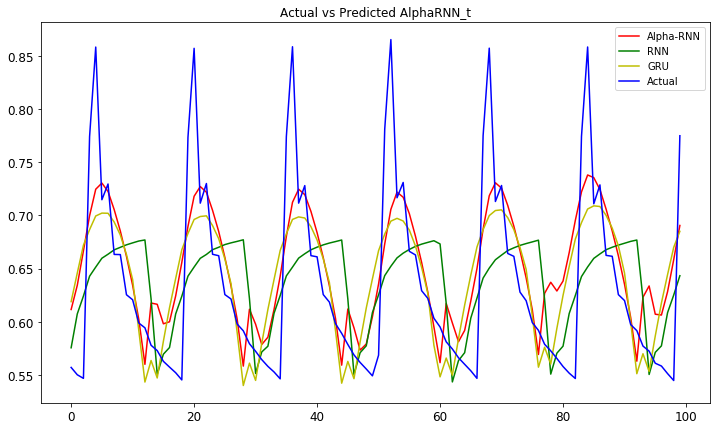

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(rs_pred_train[100:200], color='r', label='Alpha-RNN')
plt.plot(rnn_pred_train[100:200], color='g', label='RNN')
plt.plot(gru_pred_train[100:200], color='y', label='GRU')
plt.plot(y_train_reg.flatten()[100:200],'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted AlphaRNN_t')
plt.show()

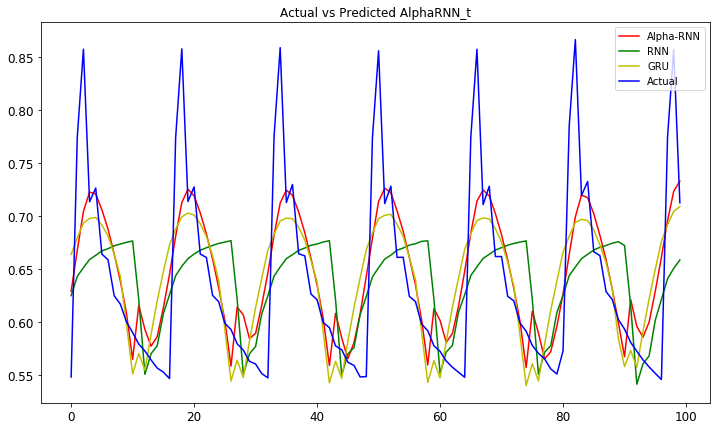

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(rs_pred_test[100:200], color='r', label='Alpha-RNN')
plt.plot(rnn_pred_test[100:200], color='g', label='RNN')
plt.plot(gru_pred_test[100:200], color='y', label='GRU')
plt.plot(y_test_reg.flatten()[100:200],'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted AlphaRNN_t')
plt.show()

In [0]:
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test)
print(mse)
mse = mean_squared_error(y_test_reg[:,0],rs_pred_test)
print(mse)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test)
print(mse)

0.006125738
0.0037169938
0.004285496


In [0]:
mse_std = np.math.sqrt(mse)
print(mse_std)

0.022216155077072364


In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_ar)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

0.00042334075261903065
0.02057524611320678


#Comparison with Keras models


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-3)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def AlphaRNN(hidden_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_rnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

In [0]:
rnn_model = RNN_model2(nodes_rnn,0)
rnn_fit = rnn_model.fit(x_train_reg,y_train_reg, epochs = 2000, batch_size=500, callbacks=[es])
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 35us/step


In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)
rnn.summary()

0.19906765775208535
0.1559363060075342
0.4461699875070995
0.394887713163545
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = KerasRegressor(build_fn=LSTM_model2, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
lstm_model = LSTM_model2(nodes_lstm,0)
lstm_fit = lstm_model.fit(x_train_reg,y_train_reg, epochs=2000, batch_size=500, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()




In [0]:
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

In [0]:
print("Hyper parameter tuning of GRU model")
model = KerasRegressor(build_fn=GRU_model2, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
gru_model = GRU_model2(nodes_gru,0)
gru_fit = gru_model.fit(x_train_reg,y_train_reg, epochs=2000, batch_size=500, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

In [0]:
# MFD: Also try GRU, SimpleRNN
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)
#gru_model = Sequential()
#gru_model.add(GRU(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#gru_model.add(Dense(1))
#gru_model.compile(loss='mean_squared_error', optimizer='adam')

#gru_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

In [0]:
#gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

374/374 [==============================] - 0s 99us/step
GRU test data mse = 0.00038023759714453945
GRU test std mse =  0.01949968197547179
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

In [0]:


hidden_size = 5
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

In [0]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_size = 5
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

In [0]:
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse = " + str(np.sqrt(mse)))

374/374 [==============================] - 0s 87us/step
LSTM test data mse = 0.0005170304470553611
LSTM test std mse = 0.02273830352192883


In [0]:
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 95us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 37us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 63us/step


In [0]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 47us/step


In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 42us/step


In [0]:
alphars_pred_train = alphars.predict(x_train_reg, verbose=1)
alphars_pred_test = alphars.predict(x_test_reg, verbose=1)

769/769 [==============================] - 0s 59us/step


In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)
rnn.summary()

0.1399077543799677
0.121081112246449
0.37404244997054503
0.3479671137427343
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)
gru.summary()

0.07424276507393676
0.07905559690758904
0.272475255892965
0.28116827151652274
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 10)                360       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004928369560054375
0.0004456200560310017
0.022199931441458046
0.02110971473116114


In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnnt.summary()

0.05734081049281611
0.07950597884939051
0.23945941303865279
0.2819680457948923
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alphat_rnn_1 (AlphatRNN)     (None, 10)                260       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [0]:

MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnn.summary()

0.10049545540500747
0.09992646008412251
0.31701018186330776
0.31611146781495053
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_1 (AlphaRNN)       (None, 10)                121       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


In [0]:

MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alphars_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alphars_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alphars.summary()

0.20703221177751924
0.18144382208230647
0.45500792496122444
0.4259622308166611
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rs_4 (RS)                    (None, 10)                381       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


In [0]:
# calculate mean squared error of the alpha RNN

#MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
#print(MSE_train)
#MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
#print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.4618680691666422
0.40977381730016493


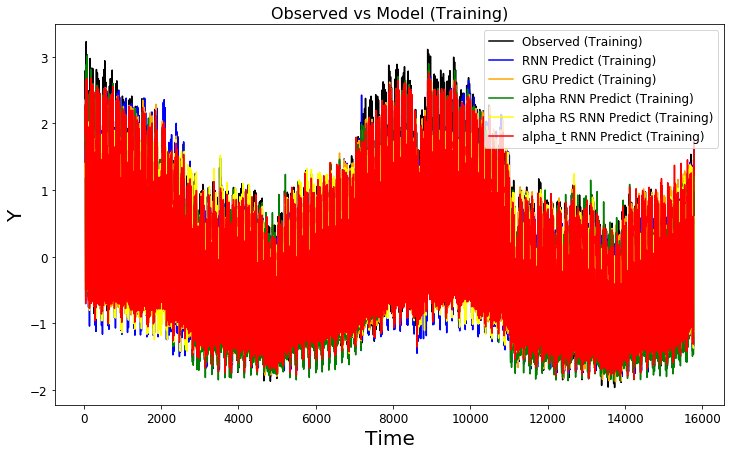

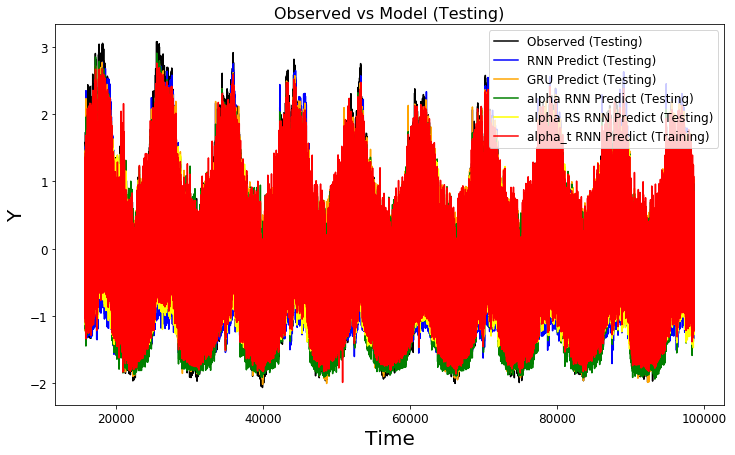

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alphars_pred_train[:,0], color="yellow", label="alpha RS RNN Predict (Training)" )
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_train[:,0], color="red", label="alpha_t RNN Predict (Training)") 

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Testing)")
#test_line_pred = plt.plot(df_test.index[n_steps:], lstm_pred_test[:, 0], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], gru_pred_test[:, 0], color="orange", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alpharnn_pred_test,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alphars_pred_test, color="yellow", label= "alpha RS RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_test[:,0], color="red", label="alpha_t RNN Predict (Training)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()